<a href="https://colab.research.google.com/github/dchlseo/data-science-practice/blob/main/DeepLearningBasics/pytorch/pytorch_mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print('current cuda device is', device)

current cuda device is cuda


In [4]:
batch_size = 50  # n = 60000 / 50 = 1200
learning_rate = 0.0001
epoch_num = 15

In [5]:
train_data = datasets.MNIST(root = './dataset',
               train = True,
               download = True,
               transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './dataset',
               train = False,
               transform = transforms.ToTensor())

print('training set: ', len(train_data))
print('training set: ', len(test_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 191677053.29it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 13443091.09it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43521354.47it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15350949.85it/s]


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

training set:  60000
training set:  10000


image shape:  torch.Size([1, 28, 28])


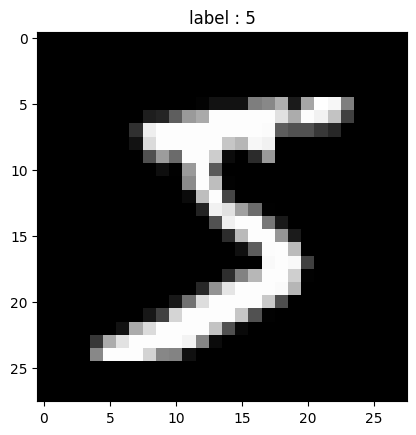

In [7]:
image, label = train_data[0]
print('image shape: ', image.shape) # [1, 28, 28]
plt.imshow(image.squeeze().numpy(), cmap = 'gray') # squeeze: [1, 28, 28] -> [28, 28]
plt.title('label : %s' % label)
plt.show()

In [8]:
# configure mini batch
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                            batch_size=batch_size,
                            shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                            batch_size=batch_size,
                            shuffle=True)
first_batch = train_loader.__iter__().__next__()

In [15]:
print('{:15s} | {:<25s} | {}' .format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}' .format('batch number', '', len(train_loader)))
print('{:15s} | {:<25s} | {}' .format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}' .format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}' .format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
batch number    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [22]:
# CNN

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')
    self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
    self.dropout = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(3136, 1000) # 7*7*64 | input/outputs of dense (fully-connected) layers
    self.fc2 = nn.Linear(1000, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2)
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output


In [23]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [26]:
model.train() # training mode
i = 1
for epoch in range(epoch_num):
  for data, target in train_loader:
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
      print('TRAIN STEP: {}\tLOSS: {: .3f}'.format(i, loss.item()))
    i += 1

TRAIN STEP: 1000	LOSS:  0.124
TRAIN STEP: 2000	LOSS:  0.099
TRAIN STEP: 3000	LOSS:  0.025
TRAIN STEP: 4000	LOSS:  0.039
TRAIN STEP: 5000	LOSS:  0.037
TRAIN STEP: 6000	LOSS:  0.021
TRAIN STEP: 7000	LOSS:  0.024
TRAIN STEP: 8000	LOSS:  0.021
TRAIN STEP: 9000	LOSS:  0.014
TRAIN STEP: 10000	LOSS:  0.013
TRAIN STEP: 11000	LOSS:  0.056
TRAIN STEP: 12000	LOSS:  0.061
TRAIN STEP: 13000	LOSS:  0.000
TRAIN STEP: 14000	LOSS:  0.003
TRAIN STEP: 15000	LOSS:  0.011
TRAIN STEP: 16000	LOSS:  0.012
TRAIN STEP: 17000	LOSS:  0.001
TRAIN STEP: 18000	LOSS:  0.010


In [27]:
model.eval() # testing mode
correct = 0
for data, target in test_loader:
  data = data.to(device)
  target = target.to(device)
  output = model(data)
  prediction = output.data.max(1)[1]
  correct += prediction.eq(target.data).sum()

print('test set accuracy: {: .2f}%' .format(100 * correct / len(test_loader.dataset)))

test set accuracy:  99.17%
